- [for more study](https://www.kaggle.com/code/mrfirdauss20/price-prediciton)

- [Mercari Price Suggestion Data](https://www.kaggle.com/datasets/djohn8/mercari-price-prediction-train-and-test-data?select=train.tsv)

### **데이터 전처리**

**데이터 구조**

- train_id: 데이터 id

- name: 제품명

- item_condition_id: 판매자가 제공하는 제품 상태

- category_name: 카테고리 명

- brand_name: 브랜드 이름

- shipping: 배송비 무료 여부, 1이면 무료(판매자 지불), 0이면 유료(구매자 지불)

- item_description: 제품에 대한 설명

- **price: 제품 가격(예측해야 하는 타겟값)** =>  제품 예상 가격을 판매자들에게 제공

> - price : target data
- 'name' 제품명,'category_name'카테고리명, 'brand_name' 브랜드명, 'item_description' 제품 설명 : 비정형 텍스트형 피쳐
- **item description과 같은 text 형태의 비정형 data와 다른 정형 속성을 같이 사용하여 회귀를 수행**

In [1]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('/content/drive/MyDrive/Kaggle - 파이썬 머신러닝 완벽 가이드/kaggleData/MercariPricetrain.tsv', sep = '\t')
print(mercari_df.shape)
mercari_df.head(7)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma..."
6,6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...


**Null 값 확인**

In [2]:
print(mercari_df.info())
# brand_name의 null 값이 너무 많음을 알 수 있다

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


### **Target label의 분포 확인** => 책 속의 오류, Only 잔차 residuals만 정규분포를 따르면 된다.
- **회귀에서 target값의 잔차가 정규 분포를 따르는 것은 매우 중요**

> - 선형 회귀는 정확하게는 타깃값이 정규 분포를 따르는게 아니라, **잔차가 정규 분포를 따른다는 가정하에 만들어진 모델** 입니다. 일반적으로 skew된 타깃값을  log 변환하면 이런  이슈들을 전반적으로 개선하기 쉽기 때문에 적용합니다.

- https://socialinnovation.tistory.com/145

- https://walkingwithus.tistory.com/606

>- 선형 회귀 모델은 종속 변수와 하나 이상의 독립 변수 간의 선형 관계를 모델링하는 통계적 기법입니다. 이 모델은 종속 변수와 예측 변수 간의 관계를 설명하기 위해 사용됩니다. 선형 회귀 모델의 기본 가정 중 하나는 잔차(residuals)가 정규 분포를 따른다는 것입니다.
- 잔차란 모델로부터 예측된 값과 실제 관측값 간의 차이를 의미합니다. 선형 회귀 모델에서는 잔차가 종속 변수의 예측값에 대한 오차를 나타냅니다. 이러한 잔차가 정규 분포를 따른다는 것은 다음과 같은 의미를 갖습니다.
1. 정규성 가정: 잔차가 정규 분포를 따른다는 것은 잔차가 평균을 중심으로 대칭적으로 분포되어 있고, 대부분의 잔차가 중심 부근에 있으며 극단값이 거의 없다는 것을 의미합니다.
2. 등분산성 가정: 잔차의 분산이 예측 값에 대해 일정하다는 것을 의미합니다. 이는 잔차가 모든 예측 값에 대해 동일한 정도로 퍼져 있다는 것을 의미합니다.
3. 독립성 가정: 잔차들은 서로 독립적이어야 합니다. 즉, 하나의 잔차가 다른 잔차에 영향을 미치지 않아야 합니다.
- 잔차가 정규 분포를 따른다는 가정은 선형 회귀 모델의 통계적 추론에 사용됩니다. 예를 들어, 잔차의 정규성을 확인하기 위해 정규성 검정을 수행하거나 잔차의 분포를 시각적으로 확인할 수 있습니다. 만약 잔차가 정규 분포를 따르지 않는다면, 모델의 신뢰도가 떨어질 수 있고, 추가적인 조치가 필요할 수 있습니다.
- 따라서 선형 회귀 모델을 적용하기 전에 잔차가 정규 분포를 따른다는 가정을 충족하는지 확인하는 것이 중요합니다.

> - **잔차가 중심 부근에 있을수록 모델이 데이터를 잘 설명하고 있음**을 나타낸다. 만약 잔차가 중심 부근에 없다면, 모델이 데이터를 충분히 설명하지 못하고 있는지 혹은 모델이 예측한 값이 실제 관측값과 얼마나 다른지에 대한 정보를 제공할 수 있습니다.
- 따라서 잔차가 중심 부근에 있는지 여부를 확인하는 것은 모델의 적합성과 예측력을 평가하는데 중요합니다. 이를 통해 모델이 얼마나 잘 작동하는지를 판단할 수 있습니다.

> **하나의 잔차가 다른 잔차에 영향을 미치는 경우**
- 이상치(outliers)나 영향점(influential points)이 있는 상황에서는 하나의 관측치가 전체 모델에 미치는 영향이 크기 때문에 다른 잔차들에도 영향을 미칠 수 있습니다.
1. **이상치 (Outliers)**: 이상치는 대부분의 데이터와는 극단적으로 다른 값을 갖는 관측치를 말합니다. 이상치는 일반적으로 모델에 큰 영향을 미칠 수 있으며, 특히 회귀 분석에서는 모델의 파라미터 추정치를 왜곡할 수 있습니다. 따라서 이상치가 있는 경우에는 잔차에도 영향을 미치게 되어 다른 잔차들이 이상치의 영향을 받을 수 있습니다.
2. **영향점 (Influential Points)**: 영향점은 회귀 분석에 대한 결과를 크게 변화시키는 관측치를 의미합니다. 이러한 관측치는 회귀 선의 기울기나 절편을 크게 변화시킬 수 있습니다. 따라서 영향점이 있는 경우 해당 관측치의 잔차가 다른 잔차들에도 영향을 미칠 수 있습니다.
3. **다중공선성 (Multicollinearity)**: 다중공선성은 독립 변수 간에 강한 상관관계가 있는 경우 발생합니다. 이러한 상황에서는 하나의 독립 변수가 다른 독립 변수와 높은 상관관계를 갖게 되어 예측 변수 간의 영향을 구분하기 어려워집니다. 이는 모델이 특정 관측치에 민감하게 반응하여 잔차에 영향을 미칠 수 있습니다.
- 이러한 상황에서는 모델의 적합성과 예측력을 신뢰할 수 있는지 확인하기 위해 추가적인 조치가 필요합니다. 따라서, 이상치나 영향점을 식별하고 적절하게 처리하여 모델의 성능을 향상시키는 것이 중요합니다.

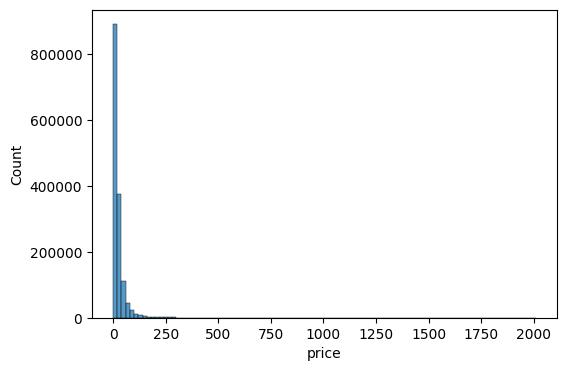

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

y_train_df = mercari_df['price']
plt.figure(figsize = (6,4))
sns.histplot(y_train_df, bins = 100)
plt.show()

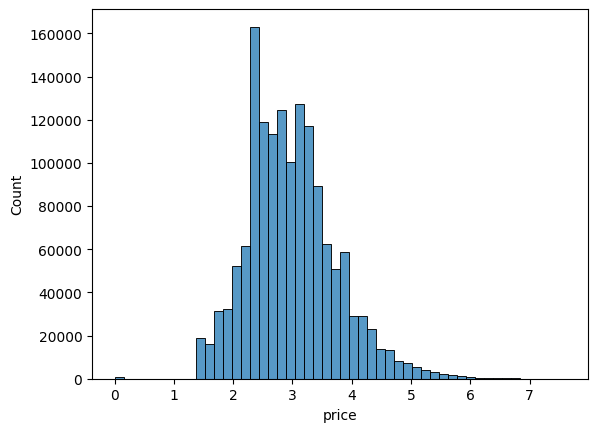

In [4]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.histplot(y_train_df, bins=50)
plt.show()

In [5]:
# data set의 price column을 원래 값에서 로그로 변환된 값으로 변경
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

>- **만약 타겟(label) 변수를 로그 변환한 경우, 모델의 예측 결과를 발표할 때는 해당 로그 변환을 역으로 취소하여 원래의 스케일로 되돌려야 합니다.** 이는 모델이 로그 변환된 값에 대해 학습하고 예측했지만, 결과를 이해하기 쉽고 해석하기 위해서는 원래의 스케일로 변환해야 하기 때문입니다.
- 예를 들어, 타겟 변수인 주택 가격을 로그 변환한 경우, 모델은 로그 변환된 가격에 대해 학습하고 예측합니다. 그러나 최종 결과를 발표할 때는 이러한 로그 변환을 역으로 취소하여 원래의 주택 가격으로 되돌려야 합니다.
- 로그 변환을 역으로 취소하는 과정은 간단합니다. 예측된 로그 변환된 값을 지수 함수(Exponential function)를 사용하여 원래의 스케일로 변환하면 됩니다. 이를 수식으로 표현하면 다음과 같습니다:

In [6]:
print('Shipping 값 유형:\n',mercari_df['shipping'].value_counts())
print('\n')
print('item_condition_id 값 유형:\n',mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 0    819435
1    663100
Name: shipping, dtype: int64


item_condition_id 값 유형:
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


In [7]:
# item_description column은 Null값은 별로 없지만, 'No description yet'과 같이 아무 설명이 없는 값들이 있다

boolean_cond= mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()

# 'No description yet'도 Null과 마찬가지로 의미있는 값이 아니기에 처리가 필요

82489

> "category_name" 칼럼의 경우 tokenizer를 \로 하여 단어를 분리해 벡터화할 수도 있지만, 이번 실습에서는 \를 기준으로 단어를 token화하여 각각 별도의 피처로 저장

In [8]:
# apply lambda에서 호출되는 대,중,소 분할 함수 생성, 대,중,소 값을 리스트 반환
def split_cat(category_name):
  try:
    return category_name.split('/')
  except:
    return ['Other_Null' , 'Other_Null' , 'Other_Null']

# 위의 split_cat( )을 apply lambda에서 호출하여 대,중,소 컬럼을 mercari_df에 생성.
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))
# *: * 기호는 해당 Iterable(여기서는 Series)의 요소를 unpack하여 개별 인수로 전달하는 역할

# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 갯수만 추출
print('대분류 유형 :\n', mercari_df['cat_dae'].value_counts())
print('중분류 갯수 :', mercari_df['cat_jung'].nunique())
print('소분류 갯수 :', mercari_df['cat_so'].nunique())

대분류 유형 :
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64
중분류 갯수 : 114
소분류 갯수 : 871


In [9]:
mercari_df['category_name'].apply(lambda x : split_cat(x))

0                                      [Men, Tops, T-shirts]
1          [Electronics, Computers & Tablets, Components ...
2                            [Women, Tops & Blouses, Blouse]
3                     [Home, Home Décor, Home Décor Accents]
4                                [Women, Jewelry, Necklaces]
                                 ...                        
1482530                           [Women, Dresses, Mid-Calf]
1482531                         [Kids, Girls 2T-5T, Dresses]
1482532    [Sports & Outdoors, Exercise, Fitness accessor...
1482533               [Home, Home Décor, Home Décor Accents]
1482534                [Women, Women's Accessories, Wallets]
Name: category_name, Length: 1482535, dtype: object

> pandas의 apply lambda로 반환되는 data set은 list를 요소로 가지고 있는데, 이를 다시 대,중,소의 dataframe으로 분리해야 한다. 따라서, zip과 *을 apply lambda 식에 적용하여 여러 개의 칼럼으로 간단하게 분리

- 주어진 코드에서 `zip(*mercari_df['category_name'].apply(lambda x: split_cat(x)))` 부분은 Pandas DataFrame의 `category_name` 열에 대해 `split_cat()` 함수를 적용한 후 그 결과를 `zip()` 함수로 묶는 역할을 합니다. 이를 하나씩 살펴보겠습니다.

1. `mercari_df['category_name'].apply(lambda x: split_cat(x))`: 먼저, `mercari_df` DataFrame의 'category_name' 열에 있는 각각의 값에 대해 `split_cat()` 함수를 적용합니다. 이 함수는 각 카테고리 이름을 '/' 기준으로 분할하여 대, 중, 소 카테고리로 나눕니다.

2. `*`: `*` 기호는 해당 Iterable(여기서는 Series)의 요소를 unpack하여 개별 인수로 전달하는 역할을 합니다. 즉, `split_cat()` 함수의 반환값을 각각의 인수로 전달합니다.

3. `zip(*...)`: `zip()` 함수는 여러 개의 Iterable을 병렬로 처리하여 튜플로 묶어주는 역할을 합니다. 여기서 `*`를 사용하여 `split_cat()` 함수의 반환값을 unpack하고, 이를 `zip()` 함수의 인수로 전달합니다. 따라서 `zip()` 함수는 대, 중, 소 카테고리를 튜플로 묶어줍니다.

결과적으로, `zip(*mercari_df['category_name'].apply(lambda x: split_cat(x)))`는 대, 중, 소 카테고리를 튜플로 묶은 결과를 반환합니다. 이 튜플은 DataFrame의 각 행에 대응되며, 대, 중, 소 카테고리를 함께 묶어서 표현합니다.

> try except
- 주어진 코드에서 try 블록 안에 있는 코드가 먼저 실행됩니다. 여기서는 category_name을 슬래시('/')로 분할하려고 시도합니다. 이 때, 만약 category_name에 슬래시가 포함되어 있지 않거나 다른 이유로 분할이 실패하면(예를 들어, category_name이 None일 경우), 예외가 발생하게 됩니다.

- 그런 다음, 예외가 발생하면 프로그램이 except 블록으로 이동하여 해당 예외를 처리합니다. 여기서는 'Other_Null'이라는 문자열을 3번 반환하는데, 이는 분할에 실패한 경우에 대한 대체 값으로 사용됩니다. 따라서 최종적으로는 대체 값이 반환됩니다.

> zip
- zip 함수는 파이썬의 내장 함수 중 하나로, 여러 개의 순차적인(iterable) 자료형을 병렬로 처리할 때 사용됩니다. 이 함수는 각 자료형에서 동일한 인덱스에 해당하는 요소들을 묶어서 튜플로 반환합니다.



```python
list1 = [1, 2, 3]
list2 = ['a', 'b', 'c']
list3 = [True, False, True]

zipped = zip(list1, list2, list3)
# [(1, 'a', True), (2, 'b', False), (3, 'c', True)]

# zip() 함수에 pd.Series 타입의 data 입력
import pandas as pd
# pd.Series 객체 생성
data1 = pd.Series([1, 2, 3, 4, 5])
data2 = pd.Series(['a', 'b', 'c', 'd', 'e'])
# zip 함수 적용
zipped = zip(data1, data2)
# 결과 출력
for item in zipped:
    print(item)
```



brand_name, category_name, item_description 컬럼의 Null 값은 모두 "Other Null"로 변경

In [10]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value = 'Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# 각 컬럼별로 Null값 건수 확인. 모두 0가 나와야 합니다.
mercari_df.isnull().sum() # isnull => dataframe의 값 각각에 대하여 true / false 반환

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

### **Feature 인코딩 & 벡터화**

- Mercari data에는 문자열 컬럼이 많다
- 이 중 레이블 or 원핫 인코딩을 수행하거나 피처 벡터화로 변환할 칼럼 선별

> featue 인코딩 & 디코딩
- 피처 인코딩은 범주형 데이터를 기계 학습 알고리즘이 이해할 수 있는 형태로 변환하는 과정
1. 원핫 인코딩(One-Hot Encoding): 각 범주형 변수를 이진형 변수로 변환하여 각 범주를 0 또는 1의 값으로 표현합니다. 이는 각 범주가 별도의 열로 확장되는 희소 행렬(sparse matrix)을 생성합니다.
2. 레이블 인코딩(Label Encoding): 각 범주형 변수를 정수형으로 변환합니다. 이는 각 범주에 대해 고유한 정수 값을 할당하는 방식입니다.
3. 순서 인코딩(Ordinal Encoding): 범주형 변수가 순서를 가지고 있는 경우에 사용됩니다. 예를 들어, '낮음', '보통', '높음'과 같은 범주를 숫자로 변환합니다.
- 피처 디코딩은 인코딩된 데이터를 원래의 형태로 복원하는 과정입니다.
일반적으로 원핫 인코딩이나 레이블 인코딩과 같이 데이터를 변환한 후에는 디코딩이 필요하지 않을 수 있습니다.
- 그러나 경우에 따라서는 원래의 범주형 데이터로 복원해야 할 때가 있습니다. 원핫 인코딩의 경우, 각 열의 값을 다시 원래의 범주로 디코딩하여 원래의 피처 형태로 되돌릴 수 있습니다.

> - 선형 회귀 모델의 경우 원핫 인코딩 적용이 훨씬 선호됨
- 피처 벡터화의 경우 비교적 짧은 텍스트 : Count 기반 벡터화 적용
- 긴 텍스트 : tf-idf 벡터화 적용

In [11]:
# brand name Column
print('brand name 의 유형 건수 :', mercari_df['brand_name'].nunique())
print('brand name sample 5건 : \n', mercari_df['brand_name'].value_counts()[:5])

brand name 의 유형 건수 : 4810
brand name sample 5건 : 
 Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


- brand name의 경우 대부분 명료한 문자열
- 별도의 피처 벡터화가 필요 없이 인코딩 변환을 적용하면 된다
- 4810 종류의 brand로 다소 많지만, 원핫 인코딩을 적용하는 데 큰 문제는 없다

> **텍스트 데이터를 별도의 피처 벡터화를 하지 않고 인코딩 변환을 적용한다는 것은 텍스트 데이터를 토큰화(tokenization)하거나 어근 추출(lemmatization 또는 stemming) 등의 전처리 과정을 거치지 않고, 바로 벡터로 변환하는 것을 의미합니다.**
이러한 방식은 텍스트 데이터가 단순하고, 전처리 과정을 거치지 않아도 기계 학습 모델에 적용할 수 있는 경우에 주로 사용됩니다. 그러나 텍스트 데이터의 복잡성이나 정보 손실 없이 효율적으로 모델링하기 위해서는 피처 벡터화를 수행하는 것이 보다 일반적인 접근 방식입니다.

In [12]:
# name Column
print('name 의 종류 갯수 :', mercari_df['name'].nunique())
print('name sample 7건 : \n', mercari_df['name'][:7])

name 의 종류 갯수 : 1225273
name sample 7건 : 
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


- name column은 유형이 매우 많고, 적은 단어 위주의 text 형태로 되어 있기에, count 기반으로 피처 벡터화 변환 적용
- category_name 컬럼은 대,중,소 분류의 세 개의 칼럼에 원핫 인코딩을 적용
- shipping 칼럼은 0 / 1 => 원핫 인코딩
- item_condition 칼럼은 1,2,3,4,5 => 원핫 인코딩

- **item_discription 칼럼은 상품에 대한 간단 설명으로 데이터 세트에서 가장 긴 텍스트 => tf-idf 변환**

In [13]:
pd.set_option('max_colwidth', 200)
# item_description의 평균 문자열 개수
print('item_description 평균 문자열 길이:',mercari_df['item_description'].str.len().mean())
mercari_df['item_description'][:2]

item_description 평균 문자열 길이: 145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

In [14]:
# name 속성에 대한 feature vectorization 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description 에 대한 feature vectorization 변환
tfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range= (1,3) , stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:',X_name.shape)
print('item_description vectorization shape:',X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


LabelBinarizer 클래스의 sparse_output 매개변수를 True로 설정하면, 원핫 인코딩 결과를 희소 행렬(sparse matrix) 형태로 반환합니다. 이 매개변수의 기본값은 False이며, 이 경우에는 밀집(dense) 행렬 형태로 반환됩니다.

> `OneHotEncoder`와 `LabelBinarizer`는 모두 범주형 데이터를 원핫 인코딩하는 데 사용되는 도구들이다. 그러나 두 가지 클래스 간에는 몇 가지 차이점이 있다.
1. **사용 방법**:
   - `OneHotEncoder`: Scikit-learn의 `OneHotEncoder`는 대부분의 Scikit-learn 변환기와 동일한 방식으로 작동합니다. 즉, `fit`, `transform`, `fit_transform` 등의 메소드를 사용하여 모델을 학습하고 변환할 수 있습니다.
   - `LabelBinarizer`: `LabelBinarizer`는 `fit` 메소드로 학습하고 `transform` 메소드로 변환하는 대신, 한 번에 학습과 변환을 수행할 수 있는 `fit_transform` 메소드만 제공합니다.
2. **출력 형태**:
   - `OneHotEncoder`: `OneHotEncoder`는 기본적으로 희소 행렬을 출력합니다. 이는 대부분의 열이 0으로 채워진 행렬을 의미합니다.
   - `LabelBinarizer`: `LabelBinarizer`는 기본적으로 밀집(dense) 행렬을 출력합니다. 하지만 `sparse_output=True`로 설정하면 희소 행렬을 출력할 수 있습니다.
3. **적용 대상**:
   - `OneHotEncoder`: `OneHotEncoder`는 숫자로 레이블 인코딩된 범주형 데이터를 원핫 인코딩으로 변환하는 데 주로 사용됩니다.
   - **`LabelBinarizer`: `LabelBinarizer`는 문자열 형태의 범주형 데이터를 바로 원핫 인코딩으로 변환하는 데 사용됩니다. 따라서 레이블 인코딩과 원핫 인코딩을 한 번에 수행할 수 있습니다.**
4. **유연성**:
   - `OneHotEncoder`: `OneHotEncoder`는 입력 데이터가 2차원 배열 형태여야 하므로 데이터를 직접 변환하기 전에 reshape 또는 pandas DataFrame을 사용하여 변환해야 할 수 있습니다.
   - `LabelBinarizer`: `LabelBinarizer`는 단일 열의 벡터 형태 또는 2차원 배열 형태의 입력을 바로 처리할 수 있습니다.
- 따라서 `OneHotEncoder`와 `LabelBinarizer`는 사용하기에 따라 각각의 장단점이 있으며, 상황에 따라 적합한 도구를 선택하여 사용해야 합니다.


In [15]:
from sklearn.preprocessing import LabelBinarizer
# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output = True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping= LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae= lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [16]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand_shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand_shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


In [17]:
from scipy.sparse import hstack

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
# 사이파이 sparse 모듈의 hstack 함수를 이용하여 앞에서 인코딩과 Vectorization을 수행한 데이터 셋을 모두 결합.
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

import gc
# 데이터 셋이 메모리를 많이 차지하므로 사용 용도가 끝났으면 바로 메모리에서 삭제.
del X_features_sparse
gc.collect()

<class 'scipy.sparse._csr.csr_matrix'> (1482535, 161569)


0

```python
import gc
# 데이터 셋이 메모리를 많이 차지하므로 사용 용도가 끝났으면 바로 메모리에서 삭제.
del X_features_sparse
gc.collect()
```



### **릿지 회귀 모델 구축 및 평가**

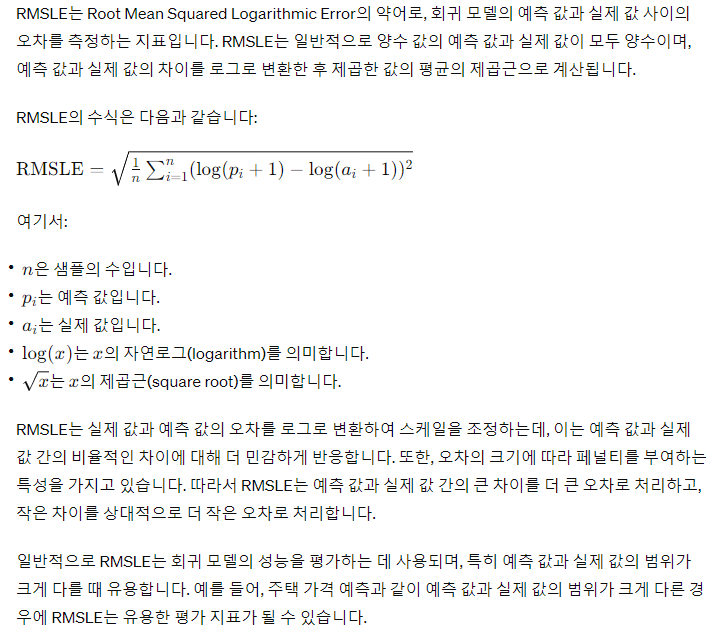

- 모델을 평가하는 평가 지표 : RMSLE
- 낮은 가격보다 높은 가격에서 오류가 발생할 경우 오류 값이 더 커지는 것을 억제하기 위해 rmsle 도입

In [18]:
def rmsle(y, r_pred):
  # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
  return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(r_pred), 2)))

def evaluate_org_price(y_test , preds):
  # 원본 데이터는 log1p로 변환되었으므로 exmpm1으로 원복 필요.
  preds_exmpm = np.expm1(preds)
  y_test_exmpm = np.expm1(y_test)

  # rmsle로 RMSLE 값 추출
  rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
  return rmsle_result

In [19]:
import gc
from scipy.sparse import hstack


def model_train_predict(model, matrix_list):
  # scipy.sparse 모듈의 hstack 을 이용하여 sparse matrix 결합
  X= hstack(matrix_list).tocsr()
  # tocsr()은 희소 행렬을 CSR 형식으로 변환하는 메소드이며, 주로 대규모 희소 행렬에 대한 효율적인 행렬 연산을 위해 사용
  X_train, X_test, y_train, y_test=train_test_split(X, mercari_df['price'], test_size=0.2, random_state=156)
  # mercari_df['price'] => log 변환된 상태

  # 모델 학습 및 예측
  model.fit(X_train , y_train)
  preds = model.predict(X_test)

  del X , X_train , X_test , y_train
  gc.collect()
  return preds , y_test

In [20]:
# Ridge를 활용한 Mercari Price 회귀 예측
# Item_description 속성이 있을 때 / 없을 때의 예측 성능 차이 확인해보기

linear_model = Ridge(solver = 'lsqr', fit_intercept = False)
sparse_matrix_list = (X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model ,matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test , linear_preds))

# 학습 data에서 X_item_cond_id 제거
sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model , matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:',  evaluate_org_price(y_test ,linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.4983990938999374
Item Description을 포함한 rmsle 값: 0.4680329023962086


### **LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가**

- LightGBM 모델 예측값을 이전의 릿지 모델의 예측값과 간단한 앙상블 방식으로 섞어서 최종 회귀 예측값 평가

In [1]:
from lightgbm import LGBMRegressor
sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
lgbm_model = LGBMRegressor(n_estimators=100, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds , y_test = model_train_predict(model = lgbm_model , matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:',  evaluate_org_price(y_test , lgbm_preds))

In [ ]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  evaluate_org_price(y_test , preds))